# Affective categorizaion of images

In [27]:
import tensorflow as tf
from PIL import Image
import glob
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers 
from tensorflow.keras import Model 

## Load data from Emotion6
source: http://chenlab.ece.cornell.edu/downloads.html

In [28]:
# load data from Emotion6 directiry
def get_images_and_labels(path):
    size = (128, 128)
    all_images = []
    image_names = []
    for filename in glob.glob(path + '*/*'):
        img = cv2.imread(filename)
        img = cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)
        img = np.array(img)
        all_images.append(img.tolist())
        image_names.append(filename.replace(path, ''))
    return np.array(all_images), np.array(image_names)

In [29]:
X, Y = get_images_and_labels(os.getcwd() + '/Emotion6/images/')

In [30]:
# change labels from image names to valence and arousal
# both are turned to binary to deal with class imbalance and small amount of data
def get_v_a_labels(y, path):
    all_labels = pd.read_csv(path + 'ground_truth.txt', delim_whitespace=True)
    valence = []
    arousal = []
    for name in Y:
        # row of image
        row = all_labels.loc[all_labels['[image_filename]'] == name].values.tolist()[0]
        # change continous data to 0-9 score system
        valence.append(row[1] > 4.5)
        arousal.append(row[2] > 4.5)
    return np.array(valence), np.array(arousal)

In [31]:
valence, arousal = get_v_a_labels(Y, os.getcwd() + '/Emotion6/')

## Data preprocessing

In [32]:
# nomrmalization
X = X / 255.0

In [33]:
# join valence and arousal into matrix 2 x 2
joinedY = valence * 10 + arousal
for i in range(len(joinedY)):
    if joinedY[i] == 10:
        joinedY[i] = 2
    if joinedY[i] == 11:
        joinedY[i] = 3

In [34]:
# randomly shuffle data
shuffler = np.random.permutation(X.shape[0])

X = X[shuffler]
joinedY = joinedY[shuffler]

In [35]:
# split
X_train, X_test = np.split(X, [int(len(X) * 0.9)])
joinedY_train, joinedY_test = np.split(joinedY, [int(len(joinedY) * 0.9)])

In [36]:
# one-hot encoding
joinedY_train = tf.one_hot(joinedY_train, 4)
joinedY_test = tf.one_hot(joinedY_test, 4)

In [37]:
batch_size = 32
input_shape = (128, 128, 3)

## Inecptionv3
Use pretrained Inecptionv3 model

In [38]:
# load and freeze base model
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = input_shape, include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

In [44]:
# add custom layer
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(4, activation='sigmoid')(x) # 4 - number of classes

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.00001), loss = 'binary_crossentropy', metrics = ['acc'])

In [45]:
inc_history = model.fit(X_train, joinedY_train, batch_size=batch_size, epochs=15, validation_split=0.3)

Epoch 1/15
39/39 [==============================] - 12s 246ms/step - loss: 0.7203 - acc: 0.3913 - val_loss: 0.6155 - val_acc: 0.4654
Epoch 2/15
39/39 [==============================] - 9s 235ms/step - loss: 0.5905 - acc: 0.4787 - val_loss: 0.6110 - val_acc: 0.4411
Epoch 3/15
39/39 [==============================] - 9s 237ms/step - loss: 0.5237 - acc: 0.5261 - val_loss: 0.5823 - val_acc: 0.4897
Epoch 4/15
39/39 [==============================] - 10s 253ms/step - loss: 0.4608 - acc: 0.5862 - val_loss: 0.5674 - val_acc: 0.5047
Epoch 5/15
39/39 [==============================] - 10s 252ms/step - loss: 0.4109 - acc: 0.6311 - val_loss: 0.5627 - val_acc: 0.4860
Epoch 6/15
39/39 [==============================] - 10s 254ms/step - loss: 0.3755 - acc: 0.6832 - val_loss: 0.5655 - val_acc: 0.4916
Epoch 7/15
39/39 [==============================] - 9s 243ms/step - loss: 0.3479 - acc: 0.7121 - val_loss: 0.5549 - val_acc: 0.4729
Epoch 8/15
39/39 [==============================] - 10s 257ms/step - los

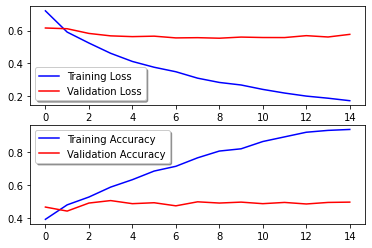

In [46]:
 # loss and accuracy curvers
fig, ax = plt.subplots(2,1)
ax[0].plot(inc_history.history['loss'], color='b', label="Training Loss")
ax[0].plot(inc_history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(inc_history.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(inc_history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [48]:
# test model
test_loss, test_acc = model.evaluate(X_test, joinedY_test)

7/7 [==============================] - 1s 119ms/step - loss: 0.5920 - acc: 0.4798


## Inceptionv3 with full training

In [55]:
base_model = InceptionV3(input_shape = input_shape, include_top = False, weights = 'imagenet')

# add custom layer
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(4, activation='sigmoid')(x) # 4 - number of classes

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.00001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
inc_history = model.fit(X_train, joinedY_train, batch_size=batch_size, epochs=25, validation_split=0.3)

Epoch 1/25
39/39 [==============================] - 51s 1s/step - loss: 0.5847 - acc: 0.3873 - val_loss: 0.6664 - val_acc: 0.4748
Epoch 2/25
39/39 [==============================] - 41s 1s/step - loss: 0.5275 - acc: 0.4691 - val_loss: 0.5790 - val_acc: 0.4766
Epoch 3/25
39/39 [==============================] - 41s 1s/step - loss: 0.4941 - acc: 0.5076 - val_loss: 0.5582 - val_acc: 0.4860
Epoch 4/25
39/39 [==============================] - 41s 1s/step - loss: 0.4715 - acc: 0.5405 - val_loss: 0.5259 - val_acc: 0.4860
Epoch 5/25
39/39 [==============================] - 43s 1s/step - loss: 0.4408 - acc: 0.5830 - val_loss: 0.5148 - val_acc: 0.4972
Epoch 6/25
39/39 [==============================] - 41s 1s/step - loss: 0.4279 - acc: 0.6047 - val_loss: 0.5153 - val_acc: 0.5252
Epoch 7/25
39/39 [==============================] - 41s 1s/step - loss: 0.4002 - acc: 0.6359 - val_loss: 0.5199 - val_acc: 0.5103
Epoch 8/25
39/39 [==============================] - 40s 1s/step - loss: 0.3765 - acc: 0.67

In [ ]:
 # loss and accuracy curvers
fig, ax = plt.subplots(2,1)
ax[0].plot(inc_history.history['loss'], color='b', label="Training Loss")
ax[0].plot(inc_history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(inc_history.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(inc_history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# test model
test_loss, test_acc = model.evaluate(x_test, y_test)

In [ ]:
# save model
model.save('my_model.h5')